# P-MOPSS: Pipeline for Magellan Optical Planetary Spectra Survey #

IMPORTANT -- before you run any code, currently you must create a directory in the location of the code called 'SaveData'. It's on my to-do list to allow user-specified save location.

UNDER CONSTRUCTION. Will allow all reduction to be run from this notebook!


In [2]:
import numpy as np
#import os

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io import fits

from setup import *
from FullFrame import FullFrame

##--------------------------------------------------------------------------##
##             NECESSARY USER INPUTS BELOW....                              ##
##--------------------------------------------------------------------------##
obs_date='ut20160811'                           #observation date
obj_name='Wasp52'                                #object name   
midtime=['2016-08-11T04:51:00']                 #time of midtransit


path='/Volumes/ermay_ext/Magellan/'+obs_date+'/'
data_path=path+obj_name+'_Spec/'      #path to where your data is saved
flat_path=path+obj_name+'_Flats/'     #path to where your SLIT flats are saved
DARKS=path+obj_name+'_Darks/'     #path to where your darks are saved
FLATS=path+'Full_Flats/'             #path to where the full field flats are saved 

SAVEPATH='SaveData/'+obj_name+'_1/'

wavelength_path=path+'WaveSolution/'



# --------------------------------------------------------------------------- 
# The following cell extracts header information.

You can add arrays in HeaderData.py following the methods there. Certain values only need to be read out for 1 chip


In [2]:
## ------------------------------------------------------------- ##
## Run this block to read header and save relevant information.  ##
## REQUIRED for observation times and number                     ##
## ------------------------------------------------------------- ##
from HeaderData import *
ReadHeader(data_path,SAVEPATH)

## This cell only needs to be run ONCE. Will save to a .npz file you can read in for the arrays
## Keys in .npz file are the names of the arrays:
##'------------------------------------------'
##'   Observing Times: obs_times[n_exp]'
##'   Object Airmass:  airmass[n_exp]'
##'   Read Noise:      elc_noise[chip]'
##'   CCD Temperature: ccd_temp[chip,n_exp]'
##'   Structure Temp:  stc_temp[chip_n_exp]'
##'   Ion Pump Press:  ion_pump[chip_n_exp]'
##'------------------------------------------'

## NOTES:
##  This cell can take a few minutes to run. I'm working on speeding up the header reading process

0 %
13 %
27 %
41 %
55 %
68 %
82 %
96 %
-->> Header Data Read
------------------------------------------
   Observing Times: obs_times[n_exp]
   Object Airmass:  airmass[n_exp]
   RA:              RA[n_exp]
   DEC:             DEC[n_exp]
   Offset Angle:    Angle_o[n_exp]
   Encoder Angle:   Angle_e[n_exp]
   Read Noise:      elc_noise[chip]
   CCD Temperature: ccd_temp[chip,n_exp]
   Structure Temp:  stc_temp[chip_n_exp]
   Ion Pump Press:  ion_pump[chip_n_exp]
------------------------------------------


In [10]:
import astropy
from astropy.time import Time

time_s=np.load(SAVEPATH+'HeaderData.npz')['obs_times']
time=Time(time_s,format='isot',scale='utc')
mid_transit=Time(midtime,format='isot',scale='utc')
time-=mid_transit
time0=np.zeros_like(time)
q=0
for i in time:
    time0[q]=i.jd
    q+=1
    
np.savez(SAVEPATH+'Obs_times.npz',times=time0)
    

# --------------------------------------------------------------------------- 
# Master Dark and Flat Frames

Master Darks and Flats are first created by stitching together two chips in the vertical direction.

They are then combined into 'Full Frame' 8-chip Master Dark and Flats

Location of Darks is currently set to:  /Volumes/ermay_ext/Magellan/ut20160811/Wasp52_Darks/
Location of Flats is currently set to:  /Volumes/ermay_ext/Magellan/ut20160811/Full_Flats/
 
 
NUMBER OF ( Darks ) FRAMES:  6
 
-->> Reading in Calibration Frame Data...
-->> Saving Calibration Frame Data...
 
 
NUMBER OF ( Flats ) FRAMES:  4
 
-->> Reading in Calibration Frame Data...
-->> Saving Calibration Frame Data...
 


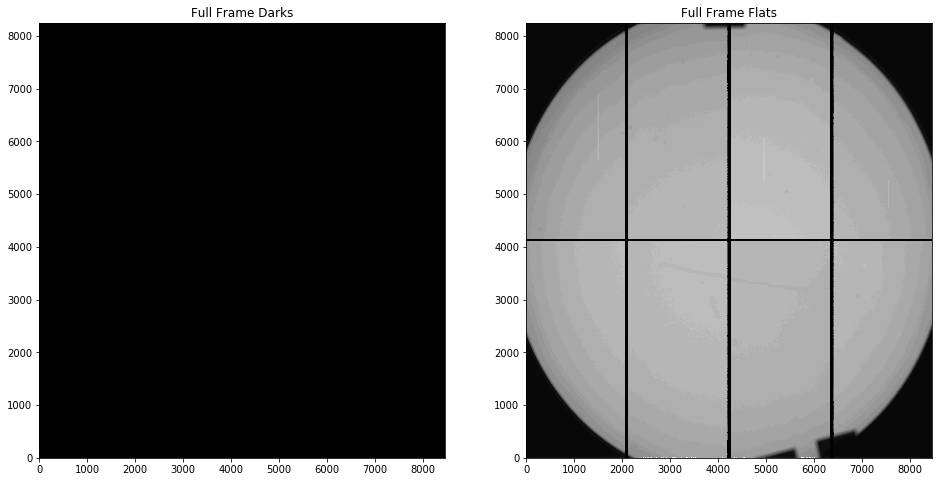

In [6]:
## ------------------------------------------------------------- ##
##     make sure your paths are updated. (first cell)            ##
## ------------------------------------------------------------- ##

print 'Location of Darks is currently set to: ', DARKS
print 'Location of Flats is currently set to: ', FLATS
print ' '

from MasterFrame import MasterFrame

dark=MasterFrame(DARKS,'Darks',SAVEPATH)                #first keyword=path, second keyword=save name
dark_full=FullFrame(1,dark)                    #number of frames, matrix of double-chip images
del dark                                       #clearing memory


flat=MasterFrame(FLATS,'Flats',SAVEPATH)
flat_full=FullFrame(1,flat)
flat_full/=np.nanmedian(flat_full)

#counter=0
#for i in range(0,flat_full.shape[0]):
#    for j in range(0,flat_full.shape[1]):
#        if flat_full[0,i,j]>1.4 or flat_full[0,i,j]<0.6:
#            ran=2
#            mini=np.max([0,i-ran])
#            maxi=np.min([i+ran,flat_full.shape[0]])
#            minj=np.max([0,j-ran])
#            maxj=np.min([j+ran,flat_full.shape[1]])
#            flat_full[0,i,j]=np.nanmedian(flat_full[0,mini:maxi,minj:maxj])
#            counter+=1
#print '           OUTLIERS: ',counter
        
del flat

##################################################################################
#####        Below: Plotting for sanity check ----                           #####
#####            if something doesn't look right, check your input locations #####
#####          (you can turn this off if you'd like, not the del commands)   #####
##################################################################################

levels_d=np.linspace(np.nanmin(dark_full[0,:,:]),np.nanmax(dark_full[0,:,:]),50)
levels_f=np.linspace(0,1.8,50)

fig,ax=plt.subplots(1,2,figsize=(16.,8.))
ax[0].contourf(dark_full[0,:,:],levels=levels_d,cmap=plt.cm.Greys_r)      
ax[0].set_title('Full Frame Darks')
ax[1].contourf(flat_full[0,:,:],levels=levels_f,cmap=plt.cm.Greys_r)
ax[1].set_title('Full Frame Flats')

del dark_full
del flat_full

# --------------------------------------------------------------------------- 
# Creates Object Masks

(these are used to later only extract the parts of the data we want)

First: Objects are located using the flat_thres variable

Second: Vertical Chips are Stitched

Third: Horizontal Chips are Stitched

Fourth: Objects are Combined across Vertical Chips. 

 CHIP ALIGNMENT:
---------------------------------
|   6   |   5   |   8   |   7   |
---------------------------------
|   1   |   2   |   3   |   4   |
---------------------------------
 
------------------------------
 Working on chips 6 & 1
------------------------------
   -->>  DATA STITCHED


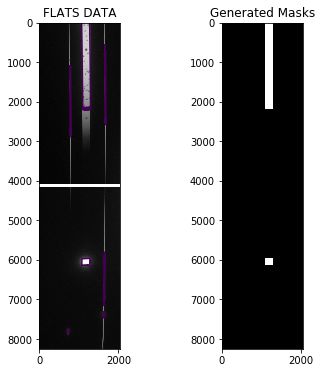

 
------------------------------
 Working on chips 5 & 2
------------------------------
   -->>  DATA STITCHED


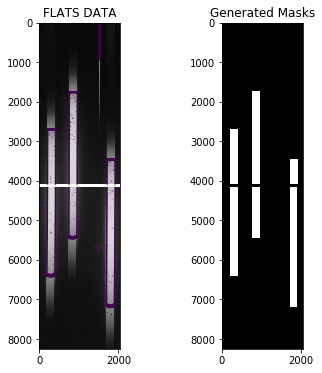

 
------------------------------
 Working on chips 8 & 3
------------------------------
   -->>  DATA STITCHED


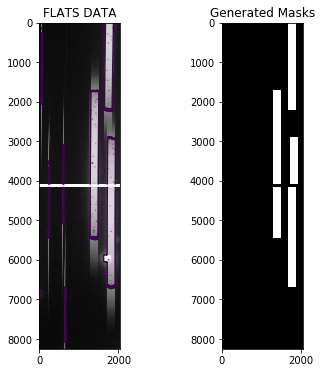

 
------------------------------
 Working on chips 7 & 4
------------------------------
   -->>  DATA STITCHED


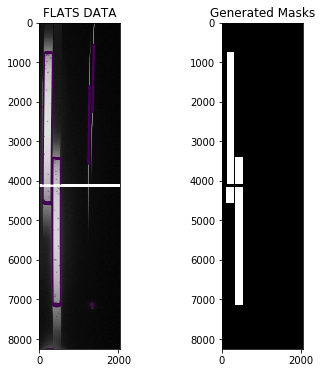

 -->> Combining Masks


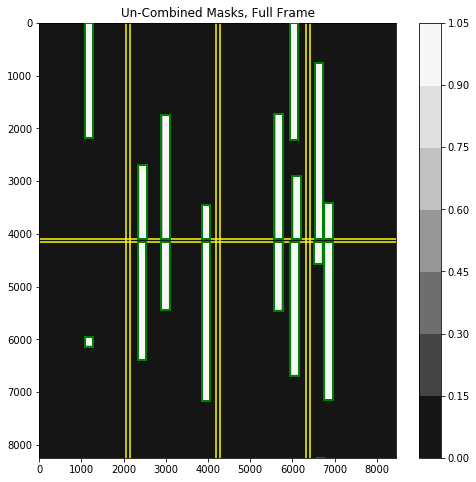

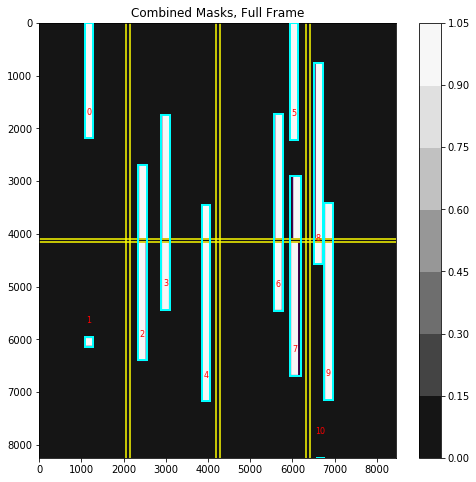

          (done)


In [8]:
## ------------------------------------------------------------- ##
## Masks are simply matrices of 1s and 0s                        ##
## ------------------------------------------------------------- ##

## user input needed:
flat_root='ift0034c'         #root name of a slit flat image
flat_thres=5000.             #flat threshold: number of counts for 'edges' of masks.

#you may need to change the flat_thres value until you like the sizes of the extracted regions.

from FindMasks import FindMasks
from FindMasks import CombineMasks
#from FullFrame import FullFrame

masks=FindMasks(flat_path,flat_root,flat_thres,SAVEPATH)
mask_full=FullFrame(1,masks)
del masks

print' -->> Combining Masks'
mask_edges=CombineMasks(mask_full,SAVEPATH)
print'          (done)'

del mask_edges

# NOTES:
# I need to find a way to ignore 0th order boxes. These can be trimmed later, for now
# this will be updated to be dependent on the median level of counts found

## last plot is sometimes small? don't know why... you can right click, open in new tab, and zoom in 

# --------------------------------------------------------------------------- 
# Define Objects: Label Target and Remove 0th-order


In [9]:
## ------------------------------------------------------------- ##
##  This rearranges masks so that the [0] element is the target  ##
##  zero-th order masks are also removed.                        ##
## ------------------------------------------------------------- ##

## using numbers output on combined mask image from cell above,define the following:
TAR=4                           #index for target
FIR=np.array([1,10])     #indices for zeroth order masks. These will be deleted


################## don't change below  ################
mask_edges=np.load(SAVEPATH+'CombinedMasks.npz')['mask_edges']
masks_fin=np.empty([mask_edges.shape[0]-len(FIR),mask_edges.shape[1]])*0.0

masks_fin[0,:]=mask_edges[TAR,:]
j=1
for i in range(0,mask_edges.shape[0]):
    if not i in FIR and i!=TAR:
        masks_fin[j,:]=mask_edges[i,:]
        j+=1
        
np.savez(SAVEPATH+'FinalMasks.npz',masks=masks_fin)
del masks_fin

# --------------------------------------------------------------------------- 
# Extract 2D Spectra for each Object #
Dark is subtracted, Flat is divided out.

In [4]:
from Extract2d import Extract2D

extra=400                             #number of extra pixels to extract per side in y direction

data=Extract2D(data_path,extra,SAVEPATH)
del data

#output is a dictionary. Keys are formated as 'obj#', with 'obj0' being the target and 'obj1'+ being calibrators
#
#invalid value encountered in divide error - IGNORE. We are dividing full frame images which include NaNs for the gaps.

 -->> Loading Masks
          (done)
 -->> Loading Flats
              1.0
          (done)
 -->> Loading Darks
              630.5
          (done)
 -->> Loading HeaderData
               145
          (done)
           ( EXTRACTED DATA FOR IMAGE  10 )  --    145  exposures total
           ( EXTRACTED DATA FOR IMAGE  20 )  --    145  exposures total
           ( EXTRACTED DATA FOR IMAGE  30 )  --    145  exposures total
           ( EXTRACTED DATA FOR IMAGE  40 )  --    145  exposures total
           ( EXTRACTED DATA FOR IMAGE  50 )  --    145  exposures total
           ( EXTRACTED DATA FOR IMAGE  60 )  --    145  exposures total
           ( EXTRACTED DATA FOR IMAGE  70 )  --    145  exposures total
           ( EXTRACTED DATA FOR IMAGE  80 )  --    145  exposures total
           ( EXTRACTED DATA FOR IMAGE  90 )  --    145  exposures total
           ( EXTRACTED DATA FOR IMAGE  100 )  --    145  exposures total
           ( EXTRACTED DATA FOR IMAGE  110 )  --    145  exposures to

# --------------------------------------------------------------------------- 
# Cosmic Ray/Outlier Correction #

https://arxiv.org/pdf/1310.0083.pdf

(note, runs from exposure 3 through n_exp-2)


In [5]:
from Outlier import medcalc,Outlier

f=5                                                               #Cut-off (pixels over f std-devs from median)

n_obj=int(np.load(SAVEPATH+'FinalMasks.npz')['masks'].shape[0])
for i in range(0,n_obj):
    Outlier(i,f,SAVEPATH)
    

-----------------
  OBJECT #  0
-----------------
    --> Loading Data...
    --> Creating Diff Images...


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


         > EXPOSURE  10
         > EXPOSURE  20
         > EXPOSURE  30
         > EXPOSURE  40
         > EXPOSURE  50
         > EXPOSURE  60
         > EXPOSURE  70
         > EXPOSURE  80
         > EXPOSURE  90
         > EXPOSURE  100
         > EXPOSURE  110
         > EXPOSURE  120
         > EXPOSURE  130
         > EXPOSURE  140
    --> Calculating Medians...
    --> Identifying Outliers...
         > EXPOSURE  10
         > EXPOSURE  20
         > EXPOSURE  30
         > EXPOSURE  40
         > EXPOSURE  50
         > EXPOSURE  60
         > EXPOSURE  70
         > EXPOSURE  80
         > EXPOSURE  90
         > EXPOSURE  100
         > EXPOSURE  110
         > EXPOSURE  120
         > EXPOSURE  130
         > EXPOSURE  140
-----------------
  OBJECT #  1
-----------------
    --> Loading Data...
    --> Creating Diff Images...
         > EXPOSURE  10
         > EXPOSURE  20
         > EXPOSURE  30
         > EXPOSURE  40
         > EXPOSURE  50
         > EXPOSURE  60
     

# --------------------------------------------------------------------------- 
# Flatten 2D Spectra #

Fits a Background function and subtracts off.

Fits a gaussian to each line of the 2D Spectra to dectect the center.

The aperture is currently done as follows: Median aperture across lambda for each frame. Varies in time. Calcualted as 3*(median(FWHM)) of the guassian fit 

-----------------
  OBJECT #  0
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  130
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  140
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE


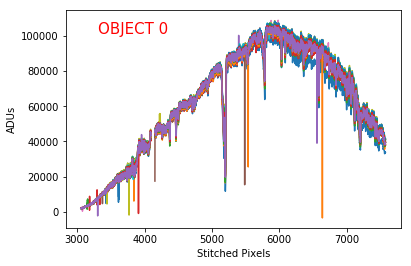

 
          time to run:  0:16:55.324989
-----------------
  OBJECT #  1
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


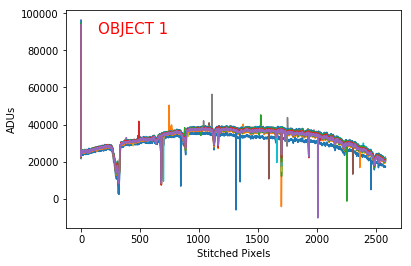

 
          time to run:  0:09:31.937944
-----------------
  OBJECT #  2
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


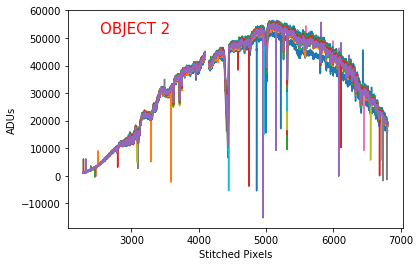

 
          time to run:  0:16:51.257149
-----------------
  OBJECT #  3
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


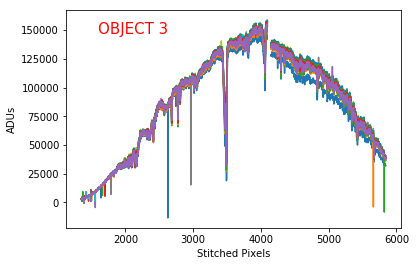

 
          time to run:  0:16:21.089841
-----------------
  OBJECT #  4
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


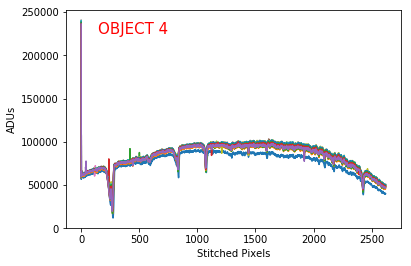

 
          time to run:  0:09:45.126298
-----------------
  OBJECT #  5
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


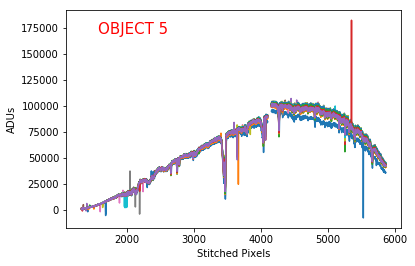

 
          time to run:  0:16:40.360445
-----------------
  OBJECT #  6
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


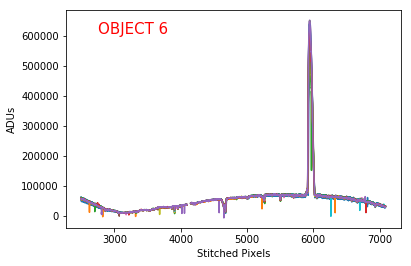

 
          time to run:  0:16:40.548288
-----------------
  OBJECT #  7
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


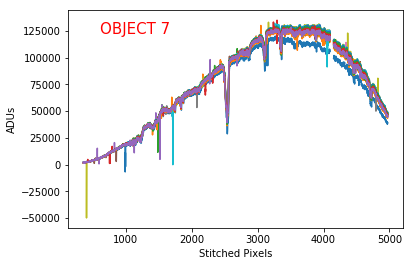

 
          time to run:  0:25:41.472408
-----------------
  OBJECT #  8
-----------------
    -->> TIME:  0
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  10
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  20
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  30
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  40
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  50
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  60
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  70
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  80
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  90
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  100
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  110
       -- FITTING GAUSSIANS
       -- SUMMING APERTURE
    -->> TIME:  120


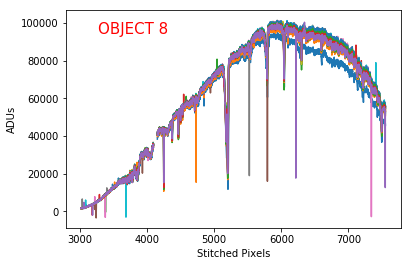

 
          time to run:  0:16:34.584451


In [6]:
from FlattenSpec import FlattenSpec

extra=400

flat_spec=FlattenSpec(extra,SAVEPATH,True)

# --------------------------------------------------------------------------- 
# Wavelength Calibration #

Not working in notebook, will eventually update this code to run this way. 

Currently: Run via command line. I'll include instructions for this part soon.

# --------------------------------------------------------------------------- 
# Time Correltation and Apply Wavelength Calibration #
This accounts for shifts in the spectral direction by oversampling the spectra by your given factor and cross correlating in time to dectect shifts down to (1/factor) of a pixel.

After correlation, all spectra are shifted as necessary and wavelength calibration is applied.

-----------------
  OBJECT #  0
-----------------
 --Filtering...
    -->> TIME:  0


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:990: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
    -->> TIME:  120
    -->> TIME:  130
    -->> TIME:  140
       -->> 1668
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  0.0
    -->> TIME:  20     pixel shift:  0.0
    -->> TIME:  30     pixel shift:  0.0
    -->> TIME:  40     pixel shift:  0.0
    -->> TIME:  50     pixel shift:  0.0
    -->> TIME:  60     pixel shift:  0.0
    -->> TIME:  70     pixel shift:  0.0
    -->> TIME:  80     pixel shift:  0.0
    -->> TIME:  90     pixel shift:  0.0
    -->> TIME:  100     pixel shift:  0.0
    -->> TIME:  110     pixel shift:  0.0
    -->> TIME:  120     pixel shift:  0.0
    -->> TIME:  130     pixel shift:  0.0
    -->> TIME:  140     pixel shift:  0.0


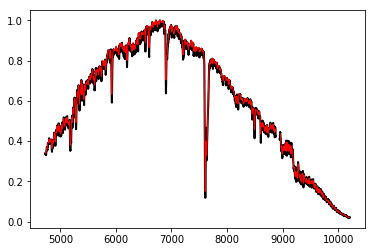

-----------------
  OBJECT #  1
-----------------
-----------------
  OBJECT #  2
-----------------
-----------------
  OBJECT #  3
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
    -->> TIME:  120
    -->> TIME:  130
    -->> TIME:  140
       -->> 2763
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  0.0
    -->> TIME:  20     pixel shift:  0.0
    -->> TIME:  30     pixel shift:  0.0
    -->> TIME:  40     pixel shift:  0.0
    -->> TIME:  50     pixel shift:  0.0
    -->> TIME:  60     pixel shift:  0.0
    -->> TIME:  70     pixel shift:  0.0
    -->> TIME:  80     pixel shift:  0.0
    -->> TIME:  90     pixel shift:  0.0
    -->> TIME:  100     pixel shift: 

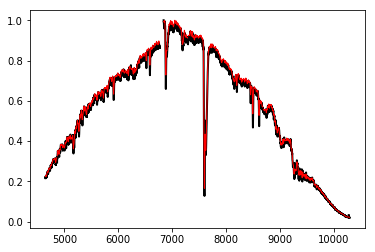

-----------------
  OBJECT #  4
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
    -->> TIME:  120
    -->> TIME:  130
    -->> TIME:  140
       -->> 2302
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  5.6
    -->> TIME:  20     pixel shift:  5.8
    -->> TIME:  30     pixel shift:  5.9
    -->> TIME:  40     pixel shift:  6.2
    -->> TIME:  50     pixel shift:  6.0
    -->> TIME:  60     pixel shift:  5.9
    -->> TIME:  70     pixel shift:  5.9
    -->> TIME:  80     pixel shift:  5.7
    -->> TIME:  90     pixel shift:  5.9
    -->> TIME:  100     pixel shift:  5.7
    -->> TIME:  110     pixel shift:  6.2
    -->> TIME:  120     pixel shift:  6.1
    -->> TI

AlignSpec.py:97: RankWarning: Polyfit may be poorly conditioned
  wav_func=np.poly1d(np.polyfit(new_pix,cor_wav,1))


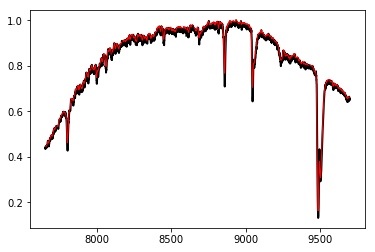

-----------------
  OBJECT #  5
-----------------
-----------------
  OBJECT #  6
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
    -->> TIME:  120
    -->> TIME:  130
    -->> TIME:  140
       -->> 3402
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  4.5
    -->> TIME:  20     pixel shift:  5.1
    -->> TIME:  30     pixel shift:  5.9
    -->> TIME:  40     pixel shift:  6.5
    -->> TIME:  50     pixel shift:  6.2
    -->> TIME:  60     pixel shift:  6.2
    -->> TIME:  70     pixel shift:  6.5
    -->> TIME:  80     pixel shift:  5.9
    -->> TIME:  90     pixel shift:  6.0
    -->> TIME:  100     pixel shift:  6.1
    -->> TIME:  110     pixel shift:  6.6
   

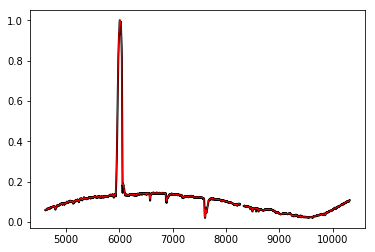

-----------------
  OBJECT #  7
-----------------
-----------------
  OBJECT #  8
-----------------
 --Filtering...
    -->> TIME:  0
    -->> TIME:  10
    -->> TIME:  20
    -->> TIME:  30
    -->> TIME:  40
    -->> TIME:  50
    -->> TIME:  60
    -->> TIME:  70
    -->> TIME:  80
    -->> TIME:  90
    -->> TIME:  100
    -->> TIME:  110
    -->> TIME:  120
    -->> TIME:  130
    -->> TIME:  140
       -->> 3749
 --Convolving with Gaussian...
 --Oversampling...
 --Cross Correlating in Time...
    -->> TIME:  0     pixel shift:  0.0
    -->> TIME:  10     pixel shift:  0.0
    -->> TIME:  20     pixel shift:  0.0
    -->> TIME:  30     pixel shift:  0.0
    -->> TIME:  40     pixel shift:  0.0
    -->> TIME:  50     pixel shift:  0.0
    -->> TIME:  60     pixel shift:  0.0
    -->> TIME:  70     pixel shift:  0.0
    -->> TIME:  80     pixel shift:  0.0
    -->> TIME:  90     pixel shift:  0.0
    -->> TIME:  100     pixel shift:  0.0
    -->> TIME:  110     pixel shift:  0.0
   

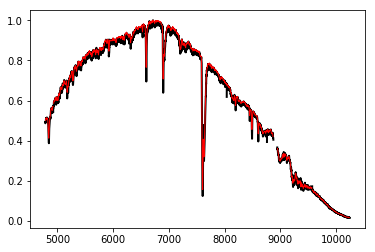

In [7]:
# to run this cell, you must have the wavelength solution text files
from AlignSpec import func_gaus
from AlignSpec import AlignSpec

osr=10
window=10

fwhm_gauss=5                    #Convolving gaussian FWHM in pixels
Aligned=AlignSpec(osr,window,fwhm_gauss,wavelength_path,obj_name,SAVEPATH)

del Aligned

# --------------------------------------------------------------------------- 
# Binning the Data

You can define the width of the bins here. 
If you'd like to do a white light curve bin, set bin=0

  -->> From Lambda= 5000  to Lambda= 8000
  -->> TOTAL OF  1 WAVELENGTH BINS
       Bin Centers:  [ 6500.]
       Bin Array:    [ 5000.  8000.]
       Bin Width:    3000
 
 >>>>>>>>>> OBJ:  0  <<<<<<<<<<
     -->> Summing up Wavelength Bins
          -> TIME 0
          -> TIME 10
          -> TIME 20
          -> TIME 30
          -> TIME 40
          -> TIME 50
          -> TIME 60
          -> TIME 70
          -> TIME 80
          -> TIME 90
          -> TIME 100
          -> TIME 110
          -> TIME 120
          -> TIME 130
          -> TIME 140


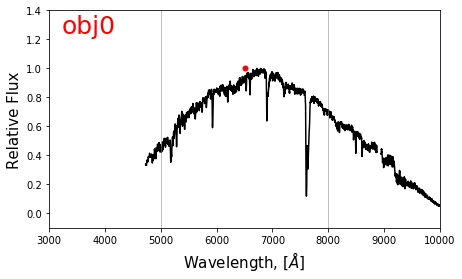

 
 >>>>>>>>>> OBJ:  3  <<<<<<<<<<
     -->> Summing up Wavelength Bins
          -> TIME 0
          -> TIME 10
          -> TIME 20
          -> TIME 30
          -> TIME 40
          -> TIME 50
          -> TIME 60
          -> TIME 70
          -> TIME 80
          -> TIME 90
          -> TIME 100
          -> TIME 110
          -> TIME 120
          -> TIME 130
          -> TIME 140


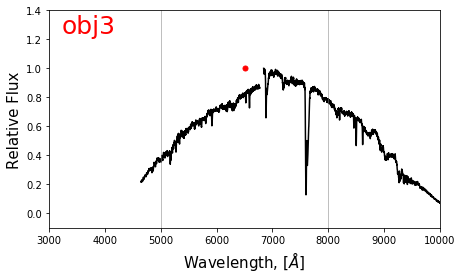

 
 >>>>>>>>>> OBJ:  4  <<<<<<<<<<
     -->> Summing up Wavelength Bins
          -> TIME 0
          -> TIME 10
          -> TIME 20
          -> TIME 30
          -> TIME 40
          -> TIME 50
          -> TIME 60
          -> TIME 70
          -> TIME 80
          -> TIME 90
          -> TIME 100
          -> TIME 110
          -> TIME 120
          -> TIME 130
          -> TIME 140


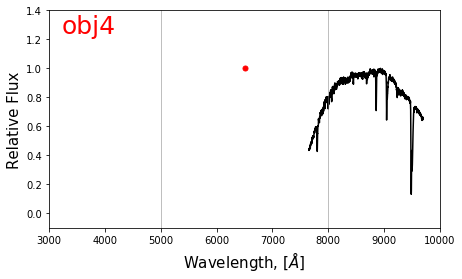

 
 >>>>>>>>>> OBJ:  6  <<<<<<<<<<
     -->> Summing up Wavelength Bins
          -> TIME 0
          -> TIME 10
          -> TIME 20
          -> TIME 30
          -> TIME 40
          -> TIME 50
          -> TIME 60
          -> TIME 70
          -> TIME 80
          -> TIME 90
          -> TIME 100
          -> TIME 110
          -> TIME 120
          -> TIME 130
          -> TIME 140


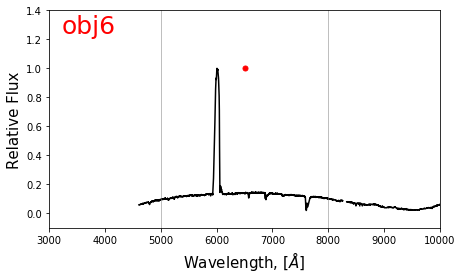

 
 >>>>>>>>>> OBJ:  8  <<<<<<<<<<
     -->> Summing up Wavelength Bins
          -> TIME 0
          -> TIME 10
          -> TIME 20
          -> TIME 30
          -> TIME 40
          -> TIME 50
          -> TIME 60
          -> TIME 70
          -> TIME 80
          -> TIME 90
          -> TIME 100
          -> TIME 110
          -> TIME 120
          -> TIME 130
          -> TIME 140


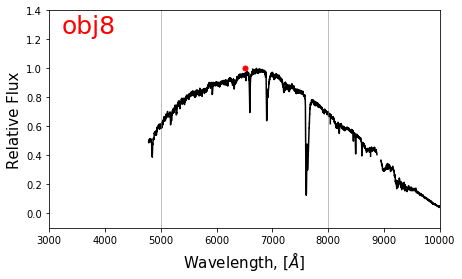

  -->> From Lambda= 5000  to Lambda= 8000
  -->> TOTAL OF  15 WAVELENGTH BINS
       Bin Centers:  [ 5100.  5300.  5500.  5700.  5900.  6100.  6300.  6500.  6700.  6900.
  7100.  7300.  7500.  7700.  7900.]
       Bin Array:    [ 5000.  5200.  5400.  5600.  5800.  6000.  6200.  6400.  6600.  6800.
  7000.  7200.  7400.  7600.  7800.  8000.]
       Bin Width:    200
 
 >>>>>>>>>> OBJ:  0  <<<<<<<<<<
     -->> Summing up Wavelength Bins
          -> TIME 0
          -> TIME 10
          -> TIME 20
          -> TIME 30
          -> TIME 40
          -> TIME 50
          -> TIME 60
          -> TIME 70
          -> TIME 80
          -> TIME 90
          -> TIME 100
          -> TIME 110
          -> TIME 120
          -> TIME 130
          -> TIME 140


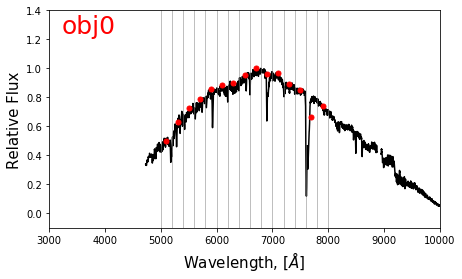

 
 >>>>>>>>>> OBJ:  3  <<<<<<<<<<
     -->> Summing up Wavelength Bins
          -> TIME 0
          -> TIME 10
          -> TIME 20
          -> TIME 30
          -> TIME 40
          -> TIME 50
          -> TIME 60
          -> TIME 70
          -> TIME 80
          -> TIME 90
          -> TIME 100
          -> TIME 110
          -> TIME 120
          -> TIME 130
          -> TIME 140


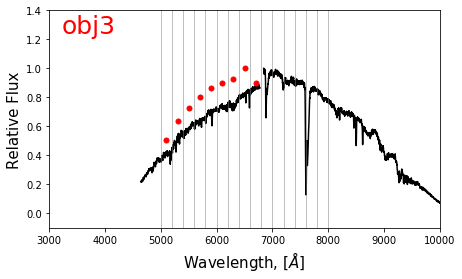

 
 >>>>>>>>>> OBJ:  4  <<<<<<<<<<
     -->> Summing up Wavelength Bins
          -> TIME 0
          -> TIME 10
          -> TIME 20
          -> TIME 30
          -> TIME 40
          -> TIME 50
          -> TIME 60
          -> TIME 70
          -> TIME 80
          -> TIME 90
          -> TIME 100
          -> TIME 110
          -> TIME 120
          -> TIME 130
          -> TIME 140


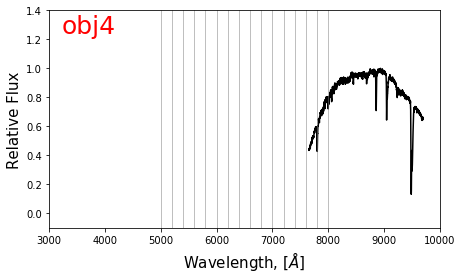

 
 >>>>>>>>>> OBJ:  6  <<<<<<<<<<
     -->> Summing up Wavelength Bins
          -> TIME 0
          -> TIME 10
          -> TIME 20
          -> TIME 30
          -> TIME 40
          -> TIME 50
          -> TIME 60
          -> TIME 70
          -> TIME 80
          -> TIME 90
          -> TIME 100
          -> TIME 110
          -> TIME 120
          -> TIME 130
          -> TIME 140


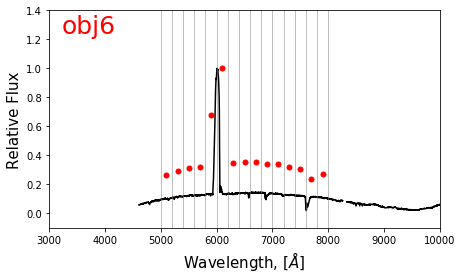

 
 >>>>>>>>>> OBJ:  8  <<<<<<<<<<
     -->> Summing up Wavelength Bins
          -> TIME 0
          -> TIME 10
          -> TIME 20
          -> TIME 30
          -> TIME 40
          -> TIME 50
          -> TIME 60
          -> TIME 70
          -> TIME 80
          -> TIME 90
          -> TIME 100
          -> TIME 110
          -> TIME 120
          -> TIME 130
          -> TIME 140


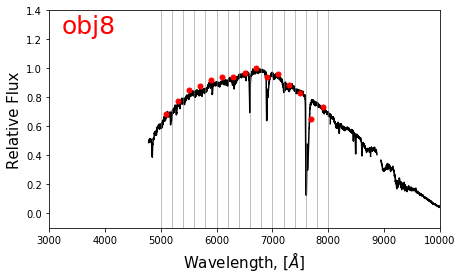

In [60]:
from Binning import BinWhite
from Binning import BinLam

start=5000
end=8000
width=200

Test=BinWhite(SAVEPATH,midtime,start,end)
Test2=BinLam(SAVEPATH,midtime,start,end,width)

In [6]:
#bins=bin_arr,bin_centers=bin_ctr,bin_counts=bin_cnt
Data=np.load(SAVEPATH+'Binned_Data_White.npz')['bin_counts']
Datal=np.load(SAVEPATH+'Binned_Data.npz')['bin_counts']

time0=np.load(SAVEPATH+'Obs_times.npz')['times']

bin_arr=np.load(SAVEPATH+'Binned_Data.npz')['bins']
bin_ctr=np.load(SAVEPATH+'Binned_Data.npz')['bin_centers']

norm=matplotlib.colors.Normalize(vmin=np.min(bin_arr),vmax=np.max(bin_arr))
#colors=matplotlib.cm.RdYlBu_r
#colors=matplotlib.cm.Spectral_r
colors=matplotlib.cm.jet
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])

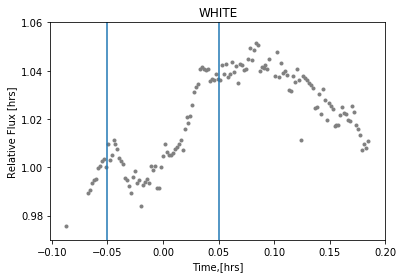

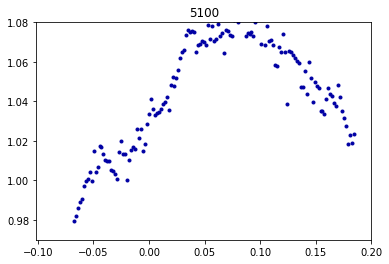

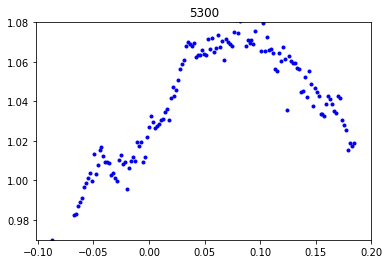

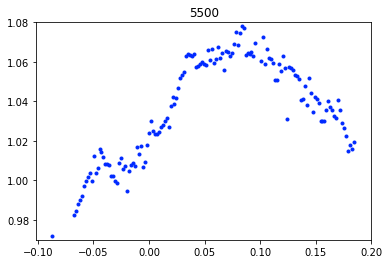

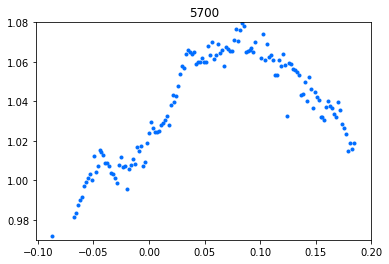

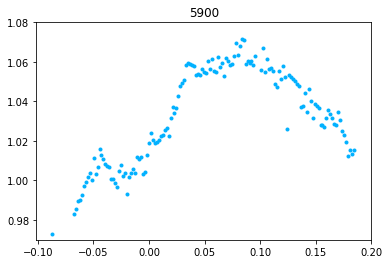

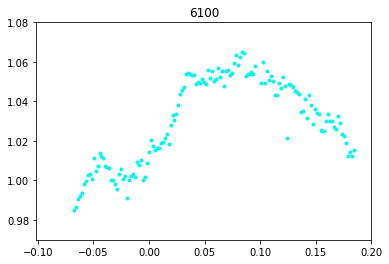

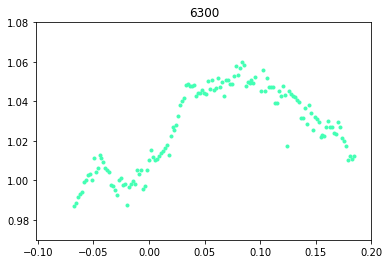

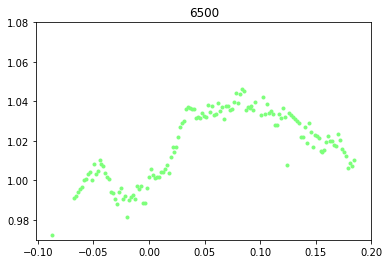

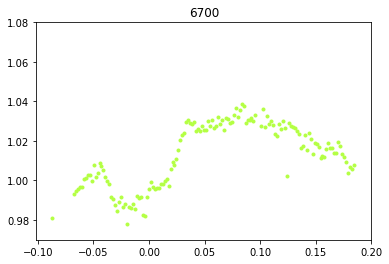

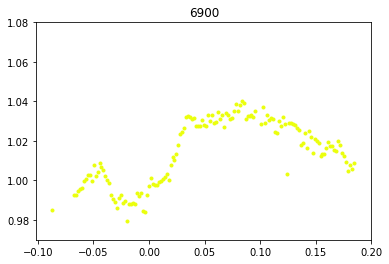

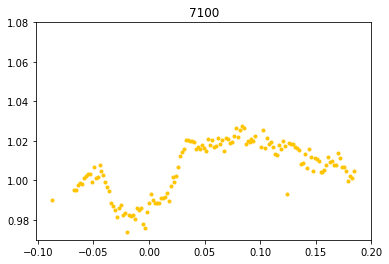

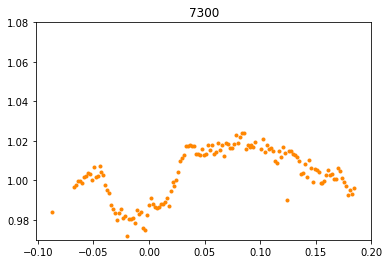

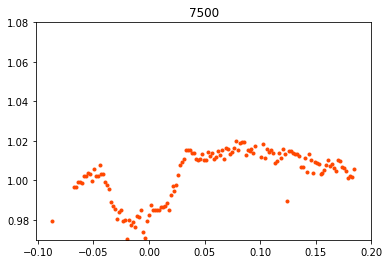

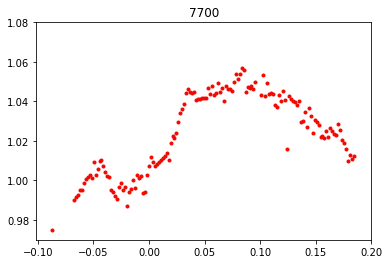

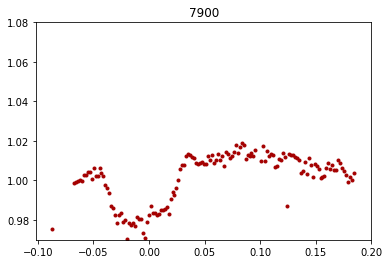

In [24]:
Cals=(np.nansum(Data[:,0,3]+Data[:,0,6]+Data[:,0,8]))
Cals=Cals/np.nanmean(Cals)
LC=(Data[:,0,0]/Cals)
LC=LC/np.nanmean(LC[0:20])
plt.plot(time0,LC,'.',color='grey')
plt.axvline(x=-0.05)
plt.axvline(x=0.05)
plt.ylim(0.97,1.06)
plt.title('WHITE')
plt.xlabel('Time,[hrs]')
plt.ylabel('Relative Flux [hrs]')
plt.show()

Cals_l=np.empty([Datal.shape[0],Datal.shape[1]])*0.0
LC_l=np.zeros_like(Cals_l)

for b in range(0,Datal.shape[1]):
    Cals_l[:,b]=(np.nansum(Datal[:,b,6]+Datal[:,b,8]))
    Cals_l[:,b]=Cals_l[:,b]/np.nanmean(Cals_l[:,b])
    LC_l[:,b]=(Datal[:,b,0]/Cals_l[:,b])
    LC_l[:,b]=LC_l[:,b]/np.nanmean(LC_l[0:20,b])
    plt.clf()
    plt.cla()
    plt.plot(time0,LC_l[:,b],'.',color=scal_m.to_rgba(bin_ctr[b]))
    plt.ylim(0.97,1.08)
    plt.title(str(int(bin_ctr[b])))
    plt.show()
    
np.savez(SAVEPATH+'LCwhite.npz',data=LC,time=time0)
np.savez(SAVEPATH+'LC_bins.npz',data=LC_l,time=time0,bin_ctr=bin_ctr)

In [12]:
head=np.load(SAVEPATH+'HeaderData.npz')
airmass=head['airmass']
obs_times=head['obs_times']
ion_pump=head['ion_pump']
elc_noise=head['elc_noise']
ccd_temp=head['ccd_temp']
RA=head['RA']
Angle_e=head['Angle_e']
n_exp=head['n_exp']
stc_temp=head['stc_temp']
DEC=head['DEC']
Angle_o=head['Angle_o']

hrs=np.load(SAVEPATH+'Obs_times.npz')['times']

np.savez(SAVEPATH+'HeaderData_ML.npz',ne=n_exp,am=airmass,ot=hrs,en=elc_noise,RA=RA,DC=DEC,ct=ccd_temp,st=stc_temp,ae=Angle_e,ao=Angle_o,ip=ion_pump)

In [14]:
import numpy as np

data=np.load(SAVEPATH+'HeaderData_ML.npz')
print data.files

['en', 'ae', 'ip', 'am', 'DC', 'ao', 'ne', 'RA', 'st', 'ot', 'ct']


In [20]:
print ion_pump.shape



(8, 145)


In [19]:
print elc_noise[:]


[ 4.9  4.9  4.9  4.9  4.9  4.9  4.9  4.9]
